In [51]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from discretize import TensorMesh
from discretize.utils import mkvc, active_from_xyz
from SimPEG.utils import plot2Ddata, model_builder
from SimPEG import maps
from SimPEG.potential_fields import magnetics

from SimPEG import (
    maps,
    data,
    inverse_problem,
    data_misfit,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

write_output = False

In [37]:
[x_topo, y_topo] = np.meshgrid(np.linspace(-200, 200, 41), np.linspace(-200, 200, 41))
z_topo = -15 * np.exp(-(x_topo**2 + y_topo**2) / 60**2)
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
xyz_topo = np.c_[x_topo, y_topo, z_topo]

In [38]:
x = np.linspace(-130.0, 130.0, 17)
y = np.linspace(-130.0, 130.0, 17)
x, y = np.meshgrid(x, y)
x, y = mkvc(x.T), mkvc(y.T)
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)
z = fun_interp(np.c_[x, y]) + 10 # Flight height 10 m above surface.
receiver_locations = np.c_[x, y, z]

components = ["tmi"]

receiver_list = magnetics.receivers.Point(receiver_locations, components=components)

receiver_list = [receiver_list]

inclination = 47.5
declination = 6.42
strength = 48843.8

source_field = magnetics.sources.UniformBackgroundField(
    receiver_list=receiver_list,
    amplitude=strength,
    inclination=inclination,
    declination=declination,
)

survey = magnetics.survey.Survey(source_field)

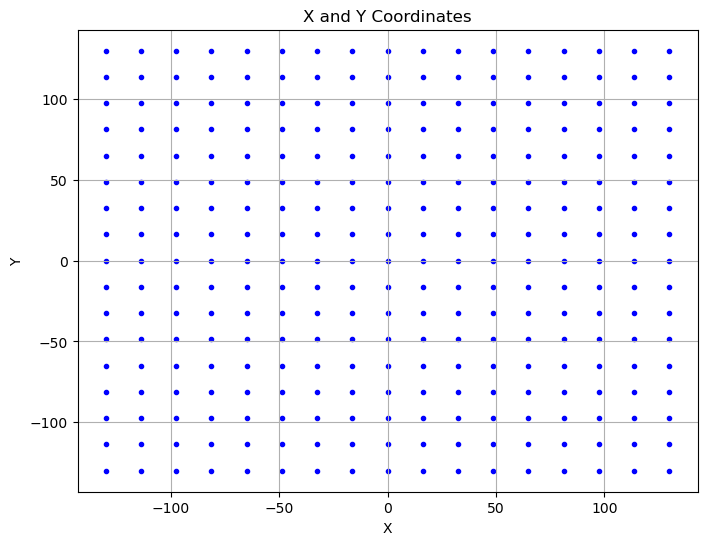

In [39]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c='b', marker='.')
plt.title('X and Y Coordinates')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

In [40]:
dh = 5.0
hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hz = [(dh, 5, -1.3), (dh, 15)]
mesh = TensorMesh([hx, hy, hz], "CCN")

In [64]:
background_susceptibility = 0.0001
#sphere_susceptibility = 0.02
mineralized_zone = 0.15
Dolerite_dyke = 0.03

ind_active = active_from_xyz(mesh, xyz_topo)

nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)

model = background_susceptibility * np.ones(ind_active.sum())

xp = np.kron(np.ones((2)), [90.0, 45.0, -100.0, -65.0])
yp = np.kron([-1000.0, 1000.0], np.ones((4)))
zp = np.kron(np.ones((2)), [-120.0, -120.0, -20, -20])
xyz_pts = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
ind_polygon = model_builder.get_indices_polygon(mesh, xyz_pts)
ind_polygon = ind_polygon[ind_active]  
model[ind_polygon] = mineralized_zone

xp = np.kron(np.ones((2)), [100.0, 90.0, 40.0, 25.0])
yp = np.kron([-10000.0, 10000.0], np.ones((4)))
zp = np.kron(np.ones((2)), [-130.0, -130.0, -20.0, -20.0])
xyz_pts = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
ind_polygon = model_builder.get_indices_polygon(mesh, xyz_pts)
ind_polygon = ind_polygon[ind_active] 
model[ind_polygon] = Dolerite_dyke

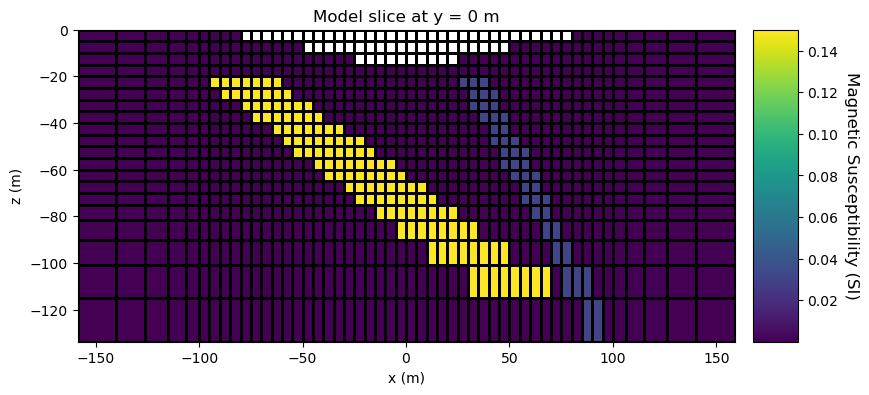

In [65]:
fig = plt.figure(figsize=(9, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plot_slice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=True,
    clim=(np.min(model), np.max(model)),
)
ax1.set_title("Model slice at y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical")
cbar.set_label("Magnetic Susceptibility (SI)", rotation=270, labelpad=15, size=12)

plt.show()

In [66]:
simulation = magnetics.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    model_type="scalar",
    chiMap=model_map,
    ind_active=ind_active,
    store_sensitivities="forward_only",
)

In [75]:
dpred = simulation.dpred(model)


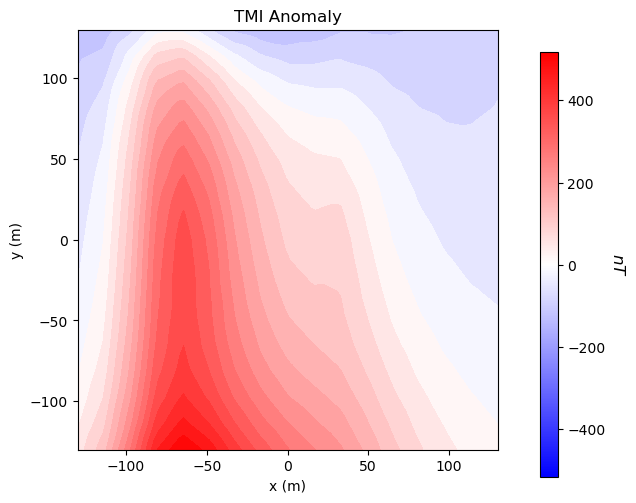

In [76]:
fig = plt.figure(figsize=(6, 5))
v_max = np.max(np.abs(dpred))

ax1 = fig.add_axes([0.1, 0.1, 0.7, 0.95])
plot2Ddata(
    receiver_list[0].locations,
    dpred,
    ax=ax1,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
ax1.set_title("TMI Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.87, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(dpred)), vmax=np.max(np.abs(dpred)))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar.set_label("$nT$", rotation=270, labelpad=15, size=12)

plt.show()

In [77]:
maximum_anomaly = np.max(np.abs(dpred))

std = 0.02 * maximum_anomaly * np.ones(len(dpred))

In [78]:
data_object = data.Data(survey, dobs=dpred, standard_deviation=std)

In [82]:
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)

# Define the regularization (model objective function)
reg = regularization.Sparse(
    mesh,
    active_cells=ind_active,
    mapping=model_map,
    reference_model=starting_model,
    gradient_type="total",
)

# Define sparse and blocky norms p, qx, qy, qz
reg.norms = [0, 0, 0, 0]

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=20, lower=0.0, upper=1.0, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [83]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Defines the directives for the IRLS regularization. This includes setting
# the cooling schedule for the trade-off parameter.
update_IRLS = directives.Update_IRLS(
    f_min_change=1e-4,
    max_irls_iterations=30,
    coolEpsFact=1.5,
    beta_tol=1e-2,
)

# Updating the preconditioner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)

# The directives are defined as a list.
directives_list = [
    sensitivity_weights,
    starting_beta,
    save_iteration,
    update_IRLS,
    update_jacobi,
]

In [84]:
inv = inversion.BaseInversion(inv_prob, directives_list)

# Print target misfit to compare with convergence
# print("Target misfit is " + str(target_misfit.target))

# Run the inversion
recovered_model = inv.run(starting_model)


                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    


IndexError: tuple index out of range